In [155]:
!pip install statsbombpy

In [156]:
!pip install torch_geometric

In [157]:
!pip install scipy==1.11.4

In [208]:
import json
import pandas as pd
import numpy as np
from collections import Counter
import networkx as nx
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import torch
from torch_geometric.data import Data
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from statsbombpy import sb
import os
import pickle
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [209]:
#### (Team, (df(x,y,#pass), p1->p2)) X2
def generate_pass_map(MATCH_ID: int):
    df = sb.events(MATCH_ID)
    if len(df) == 0:
        return None
    pass_df = df.query("(type == 'Pass') & \
                    (pass_type not in ['Free Kick', 'Corner', 'Throw-in', 'Kick Off']) & \
                    (pass_outcome not in ['Unknown','Out','Pass Offside','Injury Clearance', 'Incomplete'])"
                   ).reset_index(drop=True)

    pass_df[['pass_start_x','pass_start_y']] = pd.DataFrame(pass_df["location"].values.tolist(),
                                                            index=pass_df.index)
    pass_df[['pass_end_x','pass_end_y']] = pd.DataFrame(pass_df["pass_end_location"].values.tolist(),
                                                        index=pass_df.index)

    pass_maps = []

    for idx in range(2):
        starters = df.loc[idx, 'tactics']['lineup']
        team_name = df.loc[idx, 'team']
        team_pass_df = pass_df.query(f"team == '{team_name}'")

        if 'Substitution' in df.type.unique() or 'Red Card' in df.type.unique():
            try:
                ending_minute = df.query(f"team == '{team_name}' and type==('Substitution', 'Red Card')").minute.values[0] - 1
            except:
                return None
        else:
            ending_minute = team_pass_df.minute.max()

        team_pass_df = team_pass_df.query(f"minute <= {ending_minute}")

        player_location_df = team_pass_df.groupby(['player']).agg(
            x=('pass_start_x', 'mean'),
            y=('pass_start_y', 'mean'),
            total=('pass_start_x', 'size')
        ).reset_index()

        players_passes_df = team_pass_df.groupby(['player', 'pass_recipient']).agg(
            passes=('pass_start_x', 'size')
        ).reset_index()

        pass_maps.append((team_name, (player_location_df, players_passes_df)))

    return pass_maps

In [210]:
# create graph that can apply GCN
def create_graph_data(player_location_df, players_passes_df):
    nodes = []
    edges = []
    edge_weights = []
    node_features = []

    player_index = {player: idx for idx, player in enumerate(player_location_df['player'])}

    pass_total = sum(player_location_df['total'])

    for index, row in player_location_df.iterrows():
        nodes.append(player_index[row['player']])
        node_features.append([row['x'], row['y'], row['total'] / pass_total])

    for index, row in players_passes_df.iterrows():
        if row['player'] in player_index and row['pass_recipient'] in player_index:
            edges.append([player_index[row['player']], player_index[row['pass_recipient']]])
            edge_weights.append(row['passes'])

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    x = torch.tensor(node_features, dtype=torch.float)
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data, player_index

In [211]:
class Match:
    def __init__(self, match):
        self.match_id = match["match_id"]
        self.home_team = match["home_team"]['home_team_name']
        self.away_team = match["away_team"]['away_team_name']
        self.home_score = match["home_score"]
        self.away_score = match["away_score"]
        self.league = match["competition"]["competition_name"]
        self.season = match["season"]["season_name"]
        self.home_team_cluster = None  # Initialize cluster label for home team
        self.away_team_cluster = None  # Initialize cluster label for away team

    def _get_match_info(self):
        info = {
            "match_id" : self.match_id,
            "home_team" : self.home_team,
            "away_team" : self.away_team,
            "score" : str(self.home_score)+ ':' +str(self.away_score),
            "league" : self.league,
            "season" : self.season,
            "home_team_cluster": self.home_team_cluster,
            "away_team_cluster": self.away_team_cluster
        }
        return info

In [212]:
# Running in colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [213]:
# User path
os.chdir('/content/drive/MyDrive/CS471 Project')

In [214]:
match_list = []
for folders in os.listdir('./matches/'):
    path = os.path.join('./matches/', folders)
    if os.path.isdir(path):
        for matches in os.listdir(path):
            if matches[-1] == 'n':
                path2 = os.path.join(path, matches)
                md = pd.read_json(path2)
                for _, row in md.iterrows():
                    match = Match(row)
                    match_list.append(match)

In [215]:
LaLiga_match_id = []
SerieA_match_id = []
PL_match_id = []
Ligue1_match_id = []
Bundesliga_match_id = []
big_league_1516_id = []

for match in match_list :
    if match.league == 'La Liga' and match.season == '2015/2016':
        LaLiga_match_id.append(match.match_id)
    if match.league == 'Serie A' and match.season == '2015/2016':
        SerieA_match_id.append(match.match_id)
    if match.league == 'Premier League' and match.season == '2015/2016':
        PL_match_id.append(match.match_id)
    if match.league == 'Ligue 1' and match.season == '2015/2016':
        Ligue1_match_id.append(match.match_id)
    if match.league == '1. Bundesliga' and match.season == '2015/2016':
        Bundesliga_match_id.append(match.match_id)

big_league_1516_id = LaLiga_match_id + SerieA_match_id + PL_match_id + Ligue1_match_id + Bundesliga_match_id

print(len(LaLiga_match_id))
print(len(SerieA_match_id))
print(len(PL_match_id))
print(len(Ligue1_match_id))
print(len(Bundesliga_match_id))
print(len(big_league_1516_id))

380
380
380
377
306
1823


In [216]:
# 2-layered GCN
class GCN(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(in_channels, 16)
        self.conv2 = GCNConv(16, out_channels)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)

        return x

In [217]:
# simple mse for loss
def custom_loss(output1, output2):
    return torch.mean((output1 - output2) ** 2)

# use batch size 30, and epoch 7 for training GCN
# model changes after every batch and player_embeddings are keep updating every epoch
def train_gcn(model, match_ids, player_style, epochs, batch_size=30):
    print("MODEL TRAINING STARTS")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
    model.train()

    for epoch in range(1, epochs + 1):
        total_loss = 0
        player_style = {}
        np.random.shuffle(match_ids)  # Shuffle match_ids for each epoch

        for i in tqdm(range(0, len(match_ids), batch_size)):
            batch_ids = match_ids[i:i + batch_size]
            optimizer.zero_grad()
            batch_loss = 0

            for match_id in batch_ids:
                team_pass_maps = generate_pass_map(match_id)

                # Dealing with some error generating matches
                if team_pass_maps is None:
                    continue
                if len(team_pass_maps[0][1][0]) < 3:
                    continue

                for team_name, (player_location_df, players_passes_df) in team_pass_maps:
                    data, player_index = create_graph_data(player_location_df, players_passes_df)
                    output = model(data)

                    loss = torch.zeros(1, requires_grad=True, device=output.device)
                    for player, idx in player_index.items():
                        if player in player_style and player_style[player]:
                            for emb in player_style[player]:
                                emb_tensor = torch.tensor(emb, device=output.device)
                                loss = loss + custom_loss(output[idx], emb_tensor)

                    batch_loss += loss

                    # Update player_style with the new embeddings
                    for player, idx in player_index.items():
                        if player in player_style:
                            player_style[player].append(output[idx].detach().cpu().numpy())
                        else:
                            player_style[player] = [output[idx].detach().cpu().numpy()]

            batch_loss.backward()
            optimizer.step()
            total_loss += batch_loss.item()

        print(f"Epoch {epoch}, Loss {total_loss}")

    return player_style

In [37]:
# This is a heavy cell so it is possible to use pickle file below
model = GCN(in_channels=3, out_channels=64)
player_style = train_gcn(model, big_league_1516_id, {}, 8)

MODEL TRAINING STARTS


100%|██████████| 61/61 [16:49<00:00, 16.54s/it]


Epoch 1, Loss 494759.909576416


100%|██████████| 61/61 [15:55<00:00, 15.66s/it]


Epoch 2, Loss 367305.71852111816


100%|██████████| 61/61 [16:17<00:00, 16.03s/it]


Epoch 3, Loss 341107.67866516113


100%|██████████| 61/61 [16:27<00:00, 16.18s/it]


Epoch 4, Loss 262027.22255325317


100%|██████████| 61/61 [16:12<00:00, 15.94s/it]


Epoch 5, Loss 205016.5145225525


100%|██████████| 61/61 [16:12<00:00, 15.94s/it]


Epoch 6, Loss 184255.5615119934


100%|██████████| 61/61 [16:03<00:00, 15.79s/it]


Epoch 7, Loss 157914.23932266235


100%|██████████| 61/61 [15:58<00:00, 15.71s/it]

Epoch 8, Loss 135353.83237838745


In [38]:
with open('player_style.pickle', 'wb') as f:
  pickle.dump(player_style, f)

In [218]:
with open('player_style.pickle', 'rb') as f:
  player_style = pickle.load(f)

In [219]:
# mean-pooling to get each players' embedding vector
player_embeddings_1516 = {}
for name, styles in player_style.items():
    player_embeddings_1516[name] = np.mean(styles, axis=0)

In [220]:
from sklearn.metrics.pairwise import cosine_similarity

def find_most_similar_players(player_name, player_embeddings, top_n):
    target_vector = player_embeddings[player_name].reshape(1, -1)

    similarities = {}
    for id, vector in player_embeddings.items():
        if id != player_name:
            similarity = cosine_similarity(target_vector, vector.reshape(1, -1))[0][0]
            similarities[id] = similarity

    # Sort by similarity and extract the top N ids
    most_similar_ids = sorted(similarities, key=similarities.get, reverse=True)[:top_n]
    return most_similar_ids

input_name = "Heung-Min Son"
most_similar_players = find_most_similar_players(input_name, player_embeddings_1516, top_n=10)
print(most_similar_players)

['Raúl Albiol i Tortajada', 'Lars Edi Stindl', 'David Olatukunbo Alaba', 'Benjamin Stambouli', 'Stevan Jovetić', 'Almen Abdi', 'Eric Dier', 'Álvaro Medrán Just', 'Saphir Sliti Taïder', 'Glenn Whelan']


In [221]:
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture


player_names_1516= list(player_embeddings_1516.keys())
data_1516 = np.array(list(player_embeddings_1516.values()))
data_1516.shape

gmm = GaussianMixture(n_components=10)
labels = gmm.fit_predict(data_1516)

In [44]:
# For each player, what position did he played the most throughout the season
name_positions_list = {}
num=0

for match_id in big_league_1516_id:
    num += 1
    if num % 100 == 0:
        print(f"Processed {num} matches")
    df = sb.events(match_id)
    if len(df) == 0:
        continue

    for idx in range(2):
        starters = df.loc[idx, 'tactics']['lineup']
        for player in starters:
            if player['player']['name'] not in name_positions_list:
                name_positions_list[player['player']['name']] = [player['position']['name']]
            else:
                name_positions_list[player['player']['name']].append(player['position']['name'])

name_position = {}

for name, positions in name_positions_list.items():
    position_counter = Counter(positions)
    position, _ = position_counter.most_common(1)[0]
    name_position[name] = position

Processed 100 matches
Processed 200 matches
Processed 300 matches
Processed 400 matches
Processed 500 matches
Processed 600 matches
Processed 700 matches
Processed 800 matches
Processed 900 matches
Processed 1000 matches
Processed 1100 matches
Processed 1200 matches
Processed 1300 matches
Processed 1400 matches
Processed 1500 matches
Processed 1600 matches
Processed 1700 matches
Processed 1800 matches


100%|██████████| 2416/2416 [00:00<00:00, 711667.85it/s]


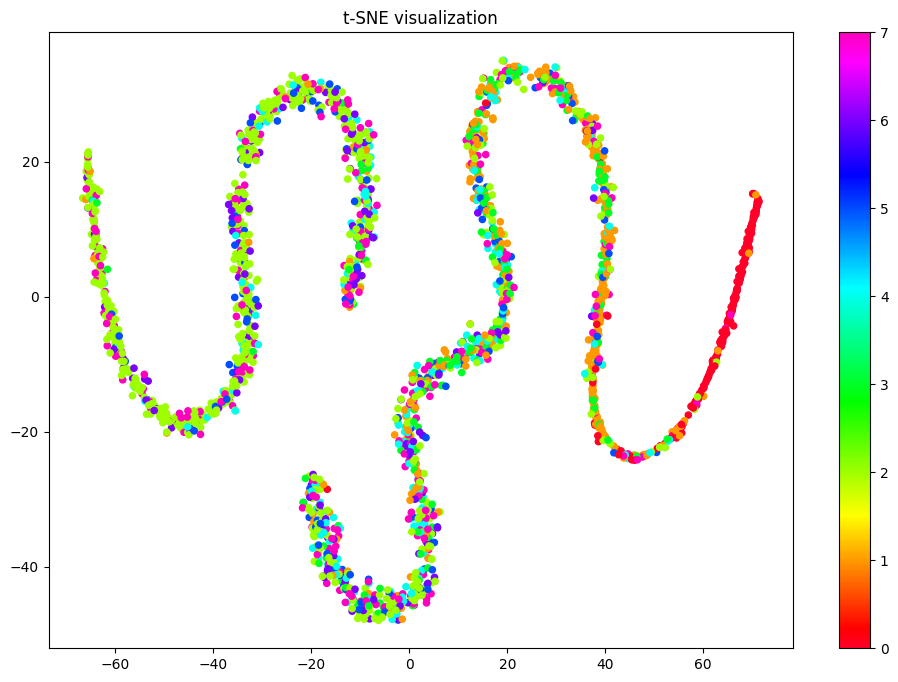

In [222]:
lcr = []
for player in tqdm(player_names_1516) :
    pos = name_position[player]

    # More well-classified results when using less class
    '''
    if pos == 'Goalkeeper' in pos:
      lcr.append(0)
    elif 'Back' in pos:
      lcr.append(1)
    elif 'Midfield' in pos:
      lcr.append(2)
    else:
      lcr.append(3)
      '''

    #However we used more class for precise results
    if pos == 'Goalkeeper' in pos:
        lcr.append(0)
    elif 'Center Back' in pos :
        lcr.append(1)
    elif 'Midfield' in pos :
        lcr.append(2)
    elif 'Left Back' in pos :
        lcr.append(3)
    elif 'Right Back' in pos :
        lcr.append(4)
    elif 'Left Wing' in pos :
        lcr.append(5)
    elif 'Right Wing' in pos :
        lcr.append(6)
    elif 'Forward' in pos :
        lcr.append(7)
    else :
        print(name_position[player])

tsne = TSNE(n_components=2, random_state=42)
data_2d = tsne.fit_transform(data_1516)
plt.figure(figsize=(12, 8))
scatter = plt.scatter(data_2d[:, 0], data_2d[:, 1], c=lcr, cmap='gist_rainbow', s=20)
plt.colorbar(scatter)
plt.title('t-SNE visualization')
plt.show()

# Team Level Analysis

In [223]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TeamPoolingModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TeamPoolingModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)

    def forward(self, player_embeddings):
        # First pooling layer
        x = torch.mean(player_embeddings, dim=0, keepdim=True)
        x = F.relu(self.fc1(x))

        # Second pooling layer
        x = torch.mean(x, dim=0, keepdim=True)
        x = F.relu(self.fc2(x))

        # Final layer
        team_embedding = self.fc3(x)
        return team_embedding.squeeze()

input_dim = player_embeddings_1516[next(iter(player_embeddings_1516))].shape[0]
hidden_dim = 128
output_dim = 64
model = TeamPoolingModel(input_dim, hidden_dim, output_dim)

In [224]:
# generate team_vectors which is array of players embedding vectors
def pool_player_embeddings_with_model(match_id, player_embeddings, generate_pass_map):
    team_vectors = {}
    team_pass_maps = generate_pass_map(match_id)

    if team_pass_maps is None:
        return None

    for team_name, (player_location_df, players_passes_df) in team_pass_maps:
        player_ids = player_location_df['player']
        team_embedding_list = []

        for player in player_ids:
            if player in player_embeddings:
                team_embedding_list.append(player_embeddings[player])

        if team_embedding_list:
            player_embeddings_tensor = torch.tensor(team_embedding_list, dtype=torch.float32)
            team_vectors[team_name] = player_embeddings_tensor

    return team_vectors

In [225]:
match_id = big_league_1516_id[0]
team_vectors = pool_player_embeddings_with_model(match_id, player_embeddings_1516, generate_pass_map)
print(team_vectors)

{'Levante UD': tensor([[ 4.8646, -6.5578,  7.3427,  6.3090,  6.1618, -4.0152,  2.8136, -2.0872,
         -4.7980,  3.3548,  1.9397, -7.9864, -1.8273, -3.5406, -2.4054,  2.4243,
          0.6308,  1.3341, -6.0114, -4.7607,  4.4404,  4.0009,  4.6004, -3.2664,
          2.1208, -2.5556, -6.0793,  1.7750,  5.1696, -3.2102,  3.3716, -2.4306,
         -3.0306,  5.5359,  9.4952, -2.5211,  4.6040, -5.2926,  3.6559, -0.9860,
          0.8179,  4.5519,  4.8536, -8.6308,  1.8120, -4.4159, -2.0505, -5.4275,
          4.5954,  2.0019,  1.7873, -6.9853,  1.8602,  0.4910, -5.2040, -6.0724,
          3.5407, -7.4772,  3.3518,  3.8725,  4.6292, -2.0409, -3.0053, -3.4188],
        [ 5.0446, -6.8092,  7.6295,  6.5435,  6.3952, -4.1546,  2.9057, -2.1530,
         -4.9779,  3.4722,  2.0052, -8.3000, -1.8791, -3.6587, -2.4732,  2.5014,
          0.6491,  1.3848, -6.2415, -4.9368,  4.6041,  4.1396,  4.7761, -3.3907,
          2.1860, -2.6357, -6.3093,  1.8369,  5.3587, -3.3141,  3.4830, -2.5126,
         -3.

In [150]:
# make meatch_result_new dataframe for convinience of analysis

all_team_vectors = []
match_results_new = []

for match_id in tqdm(big_league_1516_id):
    team_vectors = pool_player_embeddings_with_model(match_id, player_embeddings_1516, generate_pass_map)
    if team_vectors is not None:
        for team_name, vector in team_vectors.items():
            all_team_vectors.append(vector)
            for match_ in match_list:
                if match_.match_id == match_id:
                    idx = match_list.index(match_)
                    break
            match_results_new.append({
                'match_id': match_id,
                'team_name': team_name,
                'vector': vector,
                'score': match_list[idx].home_score if team_name == match_list[idx].home_team else match_list[idx].away_score
            })

match_results_new_df = pd.DataFrame(match_results_new)

100%|██████████| 1823/1823 [22:52<00:00,  1.33it/s]


In [226]:
# Remove if shape is 10 or lower
m_r = []
for match in match_results_new :
    if match['vector'].shape[0] == 11 :
        m_r.append(match)

m_r_df = pd.DataFrame(m_r)

In [227]:
# Team won: 2, draw: 1, lose: 0
def res(idx):
    matchid = m_r_df.iloc[idx]['match_id']

    if idx == 0:
        idx_cmp = idx+1
    elif idx == len(m_r_df):
        idx_cmp = idx-1
    elif matchid == m_r_df.iloc[idx-1]['match_id']:
        idx_cmp = idx-1
    else:
        idx_cmp = idx+1

    home_score = m_r_df.iloc[idx]['score']
    away_score = m_r_df.iloc[idx_cmp]['score']

    if home_score > away_score:
        return 2
    elif home_score < away_score:
        return 0
    else:
        return 1


In [228]:
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, TensorDataset

team_vectors = [result['vector'] for _,result in m_r_df.iterrows()]
team_vectors = torch.stack(team_vectors)
match_outcomes = torch.tensor([res(idx) for idx in range(len(m_r_df))])

dataset = TensorDataset(team_vectors, match_outcomes)

In [229]:
# Predict model by neural network
class OutcomePredictionModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(OutcomePredictionModel, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # No activation here, CrossEntropyLoss will apply softmax
        return x

input_size = len(m_r_df.iloc[0]['vector'])
hidden_size = 128
num_classes = 3

model2 = OutcomePredictionModel(input_size, hidden_size, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [230]:
# Perform pooling in layers
class Pooling_Classfication_Model(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, hidden_c_dim):
        super(Pooling_Classfication_Model, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.fc3 = nn.Linear(output_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, hidden_c_dim)
        self.fc5 = nn.Linear(hidden_c_dim, 3)

    def forward(self, player_embeddings):
        # First pooling layer
        x = torch.mean(player_embeddings, dim=1)  # shape: [batch_size, input_dim]
        x = F.relu(self.fc1(x))  # shape: [batch_size, hidden_dim]
        x = self.fc2(x)  # shape: [batch_size, output_dim]
        x = F.relu(self.fc3(x))  # shape: [batch_size, hidden_dim]
        x = F.relu(self.fc4(x))  # shape: [batch_size, hidden_c_dim]

        # Output layer
        x = self.fc5(x)
        return x

model = Pooling_Classfication_Model(64, 128, 64, 32)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [239]:
# Perform K-fold cross validation with 8 splits
dataset = TensorDataset(team_vectors, match_outcomes)
kf = KFold(n_splits=10)
results = []

for train_index, test_index in kf.split(team_vectors):
    train_dataset = TensorDataset(team_vectors[train_index], match_outcomes[train_index])
    test_dataset = TensorDataset(team_vectors[test_index], match_outcomes[test_index])

    train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=10, shuffle=False)

    # Training the model
    for epoch in range(50):  # Reduced number of epochs for demonstration
        model.train()
        for vectors, outcomes in train_loader:
            optimizer.zero_grad()
            predictions = model(vectors)
            loss = criterion(predictions, outcomes)
            loss.backward()
            optimizer.step()

    # Evaluate the model
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for vectors, outcomes in test_loader:
            predictions = model(vectors)
            predicted_classes = predictions.argmax(dim=1)
            correct += (predicted_classes == outcomes).sum().item()
            total += outcomes.size(0)

    accuracy = correct / total
    results.append(accuracy)

print(f'Average accuracy across folds: {np.mean(results)}')

Average accuracy across folds: 0.3698092720234161
